# Computational Epidemiology of COVID Mutations

by Adam Brennan \
20754985

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## ASEIR Model

This model is the basis for the research done in this project. It simulates the spread of a disease through a population using mathematical formulae

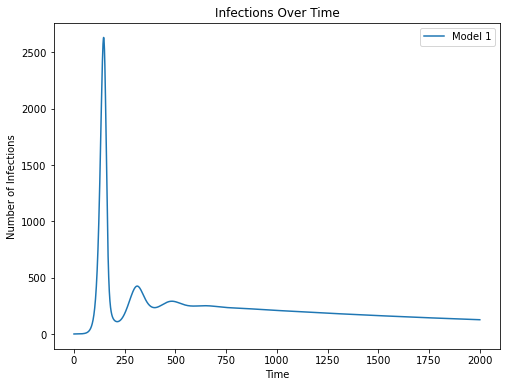

In [7]:
# constant values
N = 1000000                            # Total population
K = 10                                 # Contact Rate
alpha = 1/10                           # Incubation rate
beta = 0.3                             # Infection rate
gamma = 1/10                           # Recovery rate
p = 3/100                              # Chance of infection per interaction
b = K                                  # ???
L = 20                                 # Lag from contracting to showing symptoms
x = 1/5000                             # Probability of infection per day
f = 1/100                              # Rate at which low risk of infection causes individuals to cease responding.

times = np.arange(1, 2001)             # Number of "days" simulated

# Set aseir function to loop through times 
def aseir():
    # Initial values for ASEIR
    A = 0  
    S = N  
    E = 0  
    I = 0  
    R = 0  
    I_lag = np.zeros(len(times) + L + 1)  # list of i values at each time t
    p_lag = np.zeros(len(times) + L + 1)  # list of p values at each time t
    results = []  
    
    for t in times:
        i = (1 - (A/N)*(p*K*I_lag[t])/(x*N + p*K*I_lag[t])) * p * K * S * I / N  
        S = S - i  # Change in Susceptible individuals
        if (t == 1):
            E = 1
        else:
            E = E + i - alpha * E  # Change in Exposed individuals
        I = I + alpha * E - gamma * I  # Change in Infected individuals
        R = R + gamma * I  # Change in Recovered individuals
        A = A + b * (N - A) * I_lag[t] / N - A * f * (1 - b * I_lag[t] / N)
        I_lag[t + L] = I  # Update lagged values
        
        results.append([t, A, S, E, I, R, i])

    return results
    
    
data = aseir()
columns = ["t", "A", "S", "E", "I", "R", "i"]
df = pd.DataFrame(data, columns=columns)

plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['i'], label='Model 1')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('Infections Over Time')
plt.legend()
plt.show()

## Mutations

In [8]:
############# Mutation Class #######################
class Mutation:
    def __init__(self, p, i, i_list, E, E_list, I, I_list):
        self.p = p# (chance of infection per interaction)
        self.i = i # 
        self.i_list = i_list # (tracks number of new mutations per day)
        self.E = E # (tracks each mutations Exposed individuals)
        self.E_list = E_list # (list of all Exposed values for each mutation)
        self.I = I # (tracks each mutations Infected individuals)
        self.I_list = I_list # (list of all Infected values for each mutation)
        self.i_updated = 0
        ## make functions that calculate these for me
    
    @classmethod
    def add_mutation(cls, p, i, i_list, E, E_list, I, I_list):
        return cls(p, i, i_list, E, E_list, I, I_list)

## Hard Coded Mutations

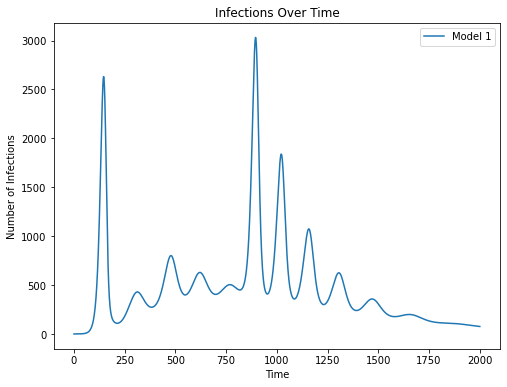

In [10]:
###### Multiple Mutations ############

# constant values
N = 1000000                            # Total population
K = 10                                 # Contact Rate
alpha = 0.1                            # Incubation rate
beta = 0.3                             # Infection rate
gamma = 0.1                            # Recovery rate
p = 0.03                               # Chance of infection per interaction 
L = 20                                 # Lag from contracting to showing symptoms
x = 0.0002                             # Probability of infection per day
f = 0.01                               # Rate at which low risk of infection causes individuals to cease responding.
b = K

times = np.arange(1, 2001)             # Number of "days" simulated

origin = Mutation.add_mutation(0.03, 0, [], 0, [], 0, [])

mutations = [origin]

# Set aseir function to loop through times 
def aseir():
    # Initial values for ASEIR
    A = 0  
    S = N  
    E = 0  
    I = 0  
    R = 0  
    I_lag = np.zeros(len(times) + L + 1)  # list of i values at each time t
    results = []  
    
    for t in times:
        
        if (t == 250):
            fill = [0] * t
            variant1 = Mutation.add_mutation(0.07, 0, fill, 0, fill, 1, fill)
            mutations.append(variant1)
            
            
        if (t == 750):
            fill = [0] * t
            variant2 = Mutation.add_mutation(0.25, 0, fill, 0, fill, 1, fill)
            mutations.append(variant2)
        
        i = 0
        for m in mutations:
            m.i = (1 - (A/N)*(m.p*K*I_lag[t])/(x*N + m.p*K*I_lag[t])) * m.p * K * S * m.I / N
            m.i_list.append(m.i)
            i += m.i
        
        S = S - i  # Change in Susceptible individuals
            
        E = 0
        if (t == 1):
            mutations[0].E = 1
            mutations[0].E_list.append(mutations[0].E)
            E = 1
        else:
            for m in mutations:
                m.E = m.E + m.i - alpha * m.E
                m.E_list.append(m.E)
                # add sum for total of E values in mutations
                E += m.E
        
        I = 0  # Change in Infected individuals
        for m in mutations:
            m.I = m.I + alpha * m.E - gamma * m.I
            m.I_list.append(m.I)
            # add sum for total of I values in mutations
            I += m.I
        
        R = R + gamma * I  # Change in Recovered individuals
        A = A + b * (N - A) * I_lag[t] / N - A * f * (1 - b * I_lag[t] / N)
        I_lag[t + L] = I  # Update lagged values
        
        results.append([t, A, S, E, I, R, i, p])

    return results
    
    
data = aseir()
columns = ["t", "A", "S", "E", "I", "R", "i", "p"]
df = pd.DataFrame(data, columns=columns)

plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['i'], label='Model 1')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('Infections Over Time')
plt.legend()
plt.show()

In [11]:
###### Structure for mutations ######

# Make bins for each mutation
# each bin should contain:
# - a value for number of people infected at time t
# - a list of values for chance to mutate to each other bin

# Use formula:
# m.i + q(I - m.I) - q(m.I)


# where q is
# -     1       2       3       4       5       6       7 
# 1 0.99999 0.00001 0.00000 0.00000 0.00000 0.00000 0.00000
# 2 0.00001 0.99998 0.00001 0.00000 0.00000 0.00000 0.00000
# 3 0.00000 0.00001 0.99998 0.00001 0.00000 0.00000 0.00000
# 4 0.00000 0.00000 0.00001 0.99998 0.00001 0.00000 0.00000
# 5 0.00000 0.00000 0.00000 0.00001 0.99998 0.00001 0.00000
# 6 0.00000 0.00000 0.00000 0.00000 0.00001 0.99998 0.00001
# 7 0.00000 0.00000 0.00000 0.00000 0.00000 0.00001 0.99999

In [12]:
# make list of mutations to choose from
mutations = []
# List of mutations
p_values = [0.03, 0.01, 0.01, 0.07, 0.01, 0.01, 0.25]  # List of p values

for mutation in p_values:
    variant1 = Mutation.add_mutation(mutation, 0, [], 0, [], 0, [])
    mutations.append(variant1)

num_mutations = len(mutations)
q_list = np.zeros((num_mutations, num_mutations))

# Set the diagonal values to 0.99998 (0.99999 in the corners)
np.fill_diagonal(q_list, 0.99998)
q_list[0][0] = 0.99999
q_list[num_mutations-1][num_mutations-1] = 0.99999
# Set the off-diagonal values to 0.00001
np.fill_diagonal(q_list[:, 1:], 0.00001)
np.fill_diagonal(q_list[1:], 0.00001)

print(q_list)

[[9.9999e-01 1.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [1.0000e-05 9.9998e-01 1.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00
  0.0000e+00]
 [0.0000e+00 1.0000e-05 9.9998e-01 1.0000e-05 0.0000e+00 0.0000e+00
  0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e-05 9.9998e-01 1.0000e-05 0.0000e+00
  0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-05 9.9998e-01 1.0000e-05
  0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-05 9.9998e-01
  1.0000e-05]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e-05
  9.9999e-01]]


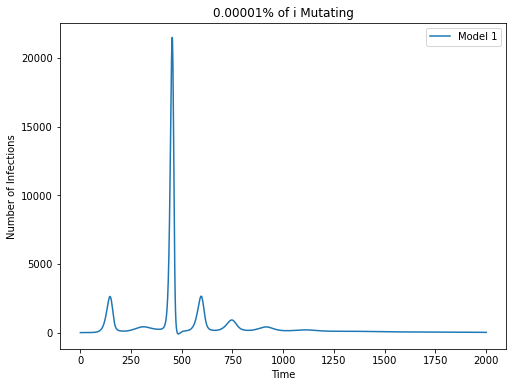

In [13]:
###### Multiple Random Mutations ############

# constant values
N = 1000000                            # Total population
K = 10                                 # Contact Rate
alpha = 0.1                            # Incubation rate
beta = 0.3                             # Infection rate
gamma = 0.1                            # Recovery rate
p = 0.03                               # Chance of infection per interaction                           
L = 20                                 # Lag from contracting to showing symptoms
x = 0.0002                             # Probability of infection per day
f = 0.01                               # Rate at which low risk of infection causes individuals to cease responding.
b = K     

times = np.arange(1, 2001)             # Number of "days" simulated

# Set aseir function to loop through times 
def aseir():
    # Initial values for ASEIR
    A = 0  
    S = N  
    E = 0  
    I = 0  
    R = 0  
    I_lag = np.zeros(len(times) + L + 1)  # list of i values at each time t
    results = []  # list to store data from aseir model
    days_without_mutation = 0  # tracks the number of days without mutation
    
    for t in times:
        
        i = 0
        for m in mutations:
            m.i = (1 - (A/N)*(m.p*K*I_lag[t])/(x*N + m.p*K*I_lag[t])) * m.p * K * S * m.I / N
            m.i_list.append(m.i)
            i += m.i
            
        for m in mutations:
            m.i_updated = m.i
            for n in mutations:
                j = mutations.index(m)
                k = mutations.index(n)
        
                # Update m.i_updated using the q_list
                m.i_updated = m.i_updated - (q_list[j, k] * m.i) + (q_list[k, j] * n.i) 
                
        for m in mutations:
            m.i = m.i_updated
            
            
        S = S - i  # change in Susceptible individuals
            
        E = 0
        if (t == 1):
            mutations[0].E = 1
            mutations[0].E_list.append(mutations[0].E)
            E = 1
        else:
            for m in mutations:
                m.E = m.E + m.i - alpha * m.E
                m.E_list.append(m.E)
                # add sum for total of E values in mutations
                E += m.E
        
        I = 0  # change in Infected individuals
        for m in mutations:
            m.I = m.I + alpha * m.E - gamma * m.I
            m.I_list.append(m.I)
            # add sum for total of I values in mutations
            I += m.I
        
        R = R + gamma * I  # change in Recovered individuals
        A = A + b * (N - A) * I_lag[t] / N - A * f * (1 - b * I_lag[t] / N)
        I_lag[t + L] = I  # update lagged values
        
        results.append([t, A, S, E, I, R, i, p])

    return results
    
data = aseir()
columns = ["t", "A", "S", "E", "I", "R", "i", "p"]
df = pd.DataFrame(data, columns=columns)

plt.figure(figsize=(8, 6))
plt.plot(df['t'], df['i'], label='Model 1')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('0.00001% of i Mutating')
plt.legend()
plt.show()

In [14]:
#################################################################################
# Confirm that total population does not fluctuate after each i calculation!!!!!
#################################################################################

Plot multiple graphs with different values to gauge how the variable affect the plot

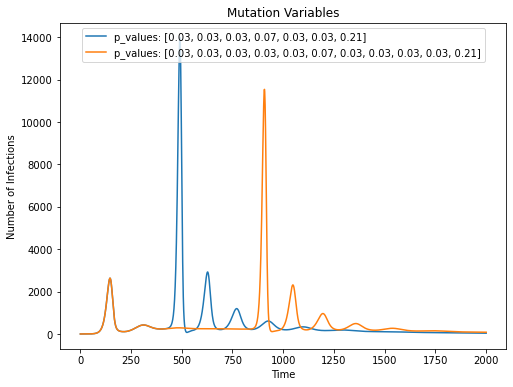

In [17]:
# make list of mutations to choose from
mutations = []
#List of mutations

p_values_list = [
    [0.03, 0.03, 0.03, 0.07, 0.03, 0.03, 0.21],
    [0.03, 0.03, 0.03, 0.03, 0.03, 0.07, 0.03, 0.03, 0.03, 0.03, 0.21]
]
#Initialize a list to store all the dataframes
all_dfs = []

# Loop over each set of p_values
for p_values in p_values_list:
    # Clear mutations list
    mutations.clear()
    
    # Create mutations
    for mutation in p_values:
        variant = Mutation.add_mutation(mutation, 0, [], 0, [], 0, [])
        mutations.append(variant)
    
    num_mutations = len(mutations)
    q_list = np.zeros((num_mutations, num_mutations))

    # Set the diagonal values to 0.99998 (0.99999 in the corners)
    np.fill_diagonal(q_list, 0.99998)
    q_list[0][0] = 0.99999
    q_list[num_mutations-1][num_mutations-1] = 0.99999
    # Set the off-diagonal values to 0.00001
    np.fill_diagonal(q_list[:, 1:], 0.00001)
    np.fill_diagonal(q_list[1:], 0.00001)

    # Run simulation
    data = aseir()
    columns = ["t", "A", "S", "E", "I", "R", "i", "p"]
    df = pd.DataFrame(data, columns=columns)
    
    # Store the dataframe
    all_dfs.append(df)

# Plot all dataframes on the same graph
plt.figure(figsize=(8, 6))
for i, df in enumerate(all_dfs):
    plt.plot(df['t'], df['i'], label=f'p_values: {p_values_list[i]}')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('Mutation Variables')
plt.legend(loc='upper center')
plt.show()


If i change the amount of p values in between spikes, it can shift the graph majorly along the x axis

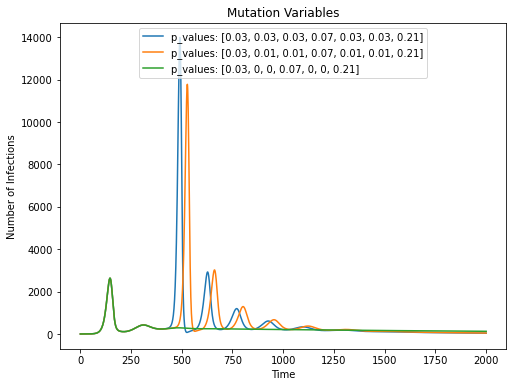

In [18]:
# make list of mutations to choose from
mutations = []
#List of mutations

p_values_list = [
    [0.03, 0.03, 0.03, 0.07, 0.03, 0.03, 0.21],
    [0.03, 0.01, 0.01, 0.07, 0.01, 0.01, 0.21],
    [0.03, 0, 0, 0.07, 0, 0, 0.21]
]
#Initialize a list to store all the dataframes
all_dfs = []

# Loop over each set of p_values
for p_values in p_values_list:
    # Clear mutations list
    mutations.clear()
    
    # Create mutations
    for mutation in p_values:
        variant = Mutation.add_mutation(mutation, 0, [], 0, [], 0, [])
        mutations.append(variant)
    
    num_mutations = len(mutations)
    q_list = np.zeros((num_mutations, num_mutations))

    # Set the diagonal values to 0.99998 (0.99999 in the corners)
    np.fill_diagonal(q_list, 0.99998)
    q_list[0][0] = 0.99999
    q_list[num_mutations-1][num_mutations-1] = 0.99999
    # Set the off-diagonal values to 0.00001
    np.fill_diagonal(q_list[:, 1:], 0.00001)
    np.fill_diagonal(q_list[1:], 0.00001)

    # Run simulation
    data = aseir()
    columns = ["t", "A", "S", "E", "I", "R", "i", "p"]
    df = pd.DataFrame(data, columns=columns)
    
    # Store the dataframe
    all_dfs.append(df)

# Plot all dataframes on the same graph
plt.figure(figsize=(8, 6))
for i, df in enumerate(all_dfs):
    plt.plot(df['t'], df['i'], label=f'p_values: {p_values_list[i]}')
plt.xlabel('Time')
plt.ylabel('Number of Infections')
plt.title('Mutation Variables')
plt.legend(loc='upper center')
plt.show()


If i change the values of p for the in between variants, (between 0, 0.01 and 0.03) then i can shift the graph slightly along the x axis.
(Note: if p = 0, model dies)